## Kayak or Paddleboard?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

Today we'll see how easy it is to implement an accurate image recognition model using the fastai library. The end-to-end process of gathering and labelling data (using the internet), training a model and evaluating on a test image (of course we would want to check the progress against a larger test set for sophisticated applications / research), takes less than 10 minutes.

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "kayak photos"
1. Use DuckDuckGo to search for images of "paddleboard photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's search for a kayak photo and seeing what kind of image we get. We'll start by getting URLs from a search:

In [11]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('kayak photos', max_images=1)
urls[0]

Searching for 'kayak photos'


'https://www.hourdetroit.com/wp-content/uploads/sites/20/2019/07/P1000155.jpg'

...and then download a URL and take a look at it:

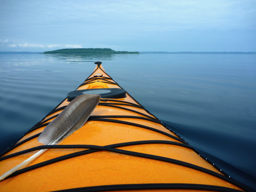

In [12]:
from fastdownload import download_url
dest = 'kayak.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "paddleboard photos":

Searching for 'paddleboard photos'


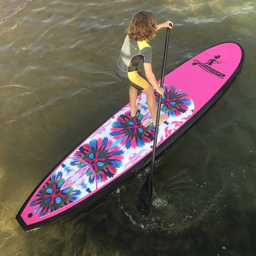

In [13]:
download_url(search_images('paddleboard photos', max_images=1)[0], 'paddleboard.jpg', show_progress=False)
Image.open('paddleboard.jpg').to_thumb(256,256)

Reasonable results! Now we can grab a few examples of each of "kayak" and "paddleboard" photos, and save each group of photos to a different folder. We can also vary the lighting conditions with simple adjustments to the search:

In [14]:
searches = 'paddleboard','kayak'
path = Path('kayak_or_paddleboard')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'paddleboard photo'
Searching for 'paddleboard sun photo'
Searching for 'paddleboard shade photo'
Searching for 'kayak photo'
Searching for 'kayak sun photo'
Searching for 'kayak shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

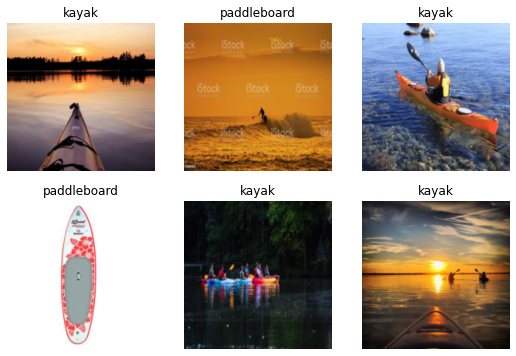

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/robin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.181226,2.762144,0.558824,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.652649,1.185589,0.352941,00:01
1,0.406627,0.427575,0.147059,00:01
2,0.283398,0.296661,0.117647,00:01


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about the kayak we downloaded at the start:

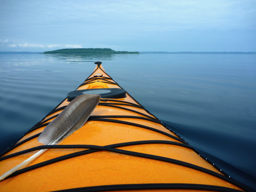

In [22]:
test_image = 'kayak.jpg'
im = Image.open(test_image)
im.to_thumb(256,256)

In [23]:
is_kayak,_,probs = learn.predict(PILImage.create(test_image))
print(f"This is a: {is_kayak}.")
print(f"Probability it's a kayak: {probs[0]:.4f}")

This is a: kayak.
Probability it's a kayak: 0.9887


Thank you, resnet18 and fastai :)

In the space of a few years, creating computer vision classification models has gone from an involved challenge to trivially easy thanks to efforts from researchers like Jeremy Howard to make the field more accessible and intuitive.

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.